In [73]:
import numpy as np
import matplotlib.pyplot as plt


"""
These are all full-batch optimizers
The mini-batched versions are easily derived, however
"""


class SGDOptimizer:
    """
    The standard gradient descent algorithm with momemtum
    """

    def __init__(self, learning_rate: float = 0.1, momentum: float = 0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.records = []


    def optimize(self, f, f_grad, z0, iter=100, verbose=True):
        self.records = []

        z = z0
        momentum = 0

        for i in range(iter):
            loss = f(z)
            self.records.append((z, loss))

            g = f_grad(z)
            momentum = momentum * self.momentum + self.learning_rate * g
            z = z - momentum
            
            if verbose:
                highest = len(str(iter-1))
                print(f"[{i:{highest}}] f({str(z):.6s}) = {f(z)}")

        return z

    def get_records(self):
        return self.records
    

class RMSPropOptimizer:
    """
    In mini-batch, the RMSProp optimizer maintains a squared average of minibatch gradients.
    It then uses the current batch gradient divided by the average of past gradients as to
    make the step size invariant of the current batch gradient (with only the sign * learning rate)
    considered. This improves learning rate and convergences - it won't oscillate.
    """


    def __init__(self, learning_rate: float = 0.1, moving_average_rate: float = 0.9):
        self.learning_rate = learning_rate
        self.moving_average_rate = moving_average_rate


    def optimize(self, f, f_grad, z0, iter=100, verbose=True):
        self.records = []

        z = z0
        grad_squared = 0

        for i in range(iter):
            loss = f(z)
            self.records.append((z, loss))
        
            g = f_grad(z)
            grad_squared = self.moving_average_rate * grad_squared + (1-self.moving_average_rate) * np.power(g, 2)
            z = z - (self.learning_rate / np.sqrt(grad_squared)) * g

             
            if verbose:
                highest = len(str(iter-1))
                print(f"[{i:{highest}}] f({str(z):.6s}) = {f(z)}")

        return z
    
    def get_records(self):
        return self.records
    

        

        



[  0] SSE = 141121519878171.25
[  1] SSE = 50.175289927466494
[  2] SSE = 50.17528992746345
[  3] SSE = 50.17528992746338
[  4] SSE = 50.17528992746345
[  5] SSE = 50.17528992746338
[  6] SSE = 50.175289927463425
[  7] SSE = 50.175289927463524
[  8] SSE = 50.175289927463496
[  9] SSE = 50.1752899274634
[ 10] SSE = 50.17528992746348
[ 11] SSE = 50.17528992746344
[ 12] SSE = 50.17528992746341
[ 13] SSE = 50.17528992746341
[ 14] SSE = 50.17528992746359
[ 15] SSE = 50.17528992746347
[ 16] SSE = 50.175289927463425
[ 17] SSE = 50.17528992746355
[ 18] SSE = 50.17528992746372
[ 19] SSE = 50.17528992746391
[ 20] SSE = 50.17528992746347
[ 21] SSE = 50.175289927463545
[ 22] SSE = 50.175289927463844
[ 23] SSE = 50.175289927463524
[ 24] SSE = 50.17528992746385
[ 25] SSE = 50.17528992746348
[ 26] SSE = 50.17528992746352
[ 27] SSE = 50.17528992746376
[ 28] SSE = 50.175289927463524
[ 29] SSE = 50.17528992746385
[ 30] SSE = 50.17528992746348
[ 31] SSE = 50.17528992746352
[ 32] SSE = 50.17528992746376
[

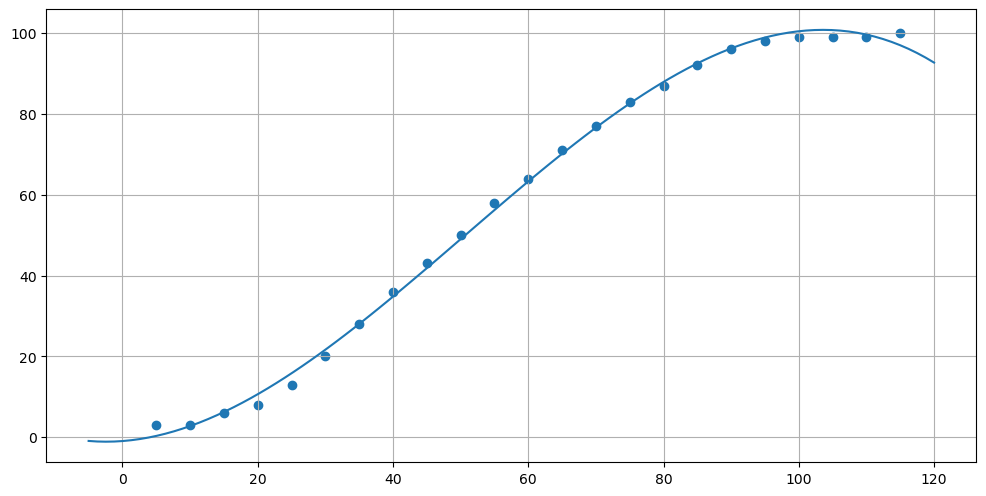

In [140]:
import csv

class GaussNewtonRegresser:
    def __init__(self) -> None:
        ...


    def fit(self, xs, ys, f, Jf, z0, iter=100, verbose=True):

        z = z0

        for i in range(iter):
            if verbose:
                highest = len(str(iter-1))
                SSE = np.sum(np.power(f(z, xs) - ys, 2))
                print(f"[{i:{highest}}] SSE = {SSE}")


            # compute residues
            r = f(z, xs) - ys
            J = Jf(z, xs)

            delta = np.linalg.inv(J.transpose() @ J) @ J.transpose() @ r

            min_a = 1
            min_sse = 1e9
            for a in np.linspace(0.4, 1, 100):
                new_z = z - a * delta
                SSE = np.sum(np.power(f(new_z, xs) - ys, 2))
                if SSE < min_sse:
                    min_sse = SSE
                    min_a = a

            z = z - min_a * delta

        
        SSE = np.sum(np.power(f(z, xs) - ys, 2))
        return z, SSE


def f(z, x):
    # L, b, k, d = z

    # return L / (1 + b * np.exp(-k * (x-d)))

    # cubic
    return z[3] * np.power(x,3) + z[2] * np.power(x,2) + z[1] * x + z[0]

def Jf(z, xs):
    # L, b, k, d = z

    data = []
    for x in xs:
        # [dr/dL, dr/db, dr/dk, dr/dd]

        # denom = (1+b*np.exp(-k * (x-d)))

        # drdl = 1/denom
        # drdb = L * (-2) * (1/denom**2) * np.exp(-k * (x-d))
        # drdk = L * (-2) * (1/denom**2) * (-b*(x-d)) * np.exp(-k * (x - d))
        # drdd = L * (-2) * (1/denom**2) * (-b*k) * np.exp(-k * (x - d)) * (-1)

        # data.append([drdl, drdb, drdk, drdd])

        data.append([1, x, x**2, x**3])

    return np.array(data)


def main():
    with open('bball.csv', 'r') as file:
        reader = csv.DictReader(file)

        xs = []
        ys = []
        for row in reader:
            xs.append(float(row['t']))
            ys.append(float(row['cumul']))

    xs = np.array(xs)
    ys = np.array(ys)

    reg = GaussNewtonRegresser()
    coef, sse = reg.fit(xs, ys, f, Jf, np.array([100, 22, 0.077, 4]), iter=130)
    # print(coef)
    print(sse)


    # graphing
    xxs = np.linspace(-5, 120, 100)
    yys = f(coef, xxs)


    plt.figure(figsize=(12, 6), dpi=100)
    plt.grid()
    plt.plot(xxs, yys)
    plt.scatter(xs, ys)
    plt.show()


# cubic model
# [-9.35064935e-01  1.28287799e-01  2.59651653e-02 -1.71115841e-04]
main()





[0] f(-0.529) = -1.0124461638644053
[1] f(-0.794) = -1.6593956648845714
[2] f(-1.036) = -2.0308541471027923
[3] f(-1.122) = -2.054973246329478
[4] f(-1.108) = -2.056156569120392
[5] f(-1.113) = -2.055964991380316
[6] f(-1.111) = -2.056067607654798
[7] f(-1.112) = -2.0560222838727507
[8] f(-1.111) = -2.0560489028536955
[9] f(-1.112) = -2.056031796665191
-1.1122820485951292


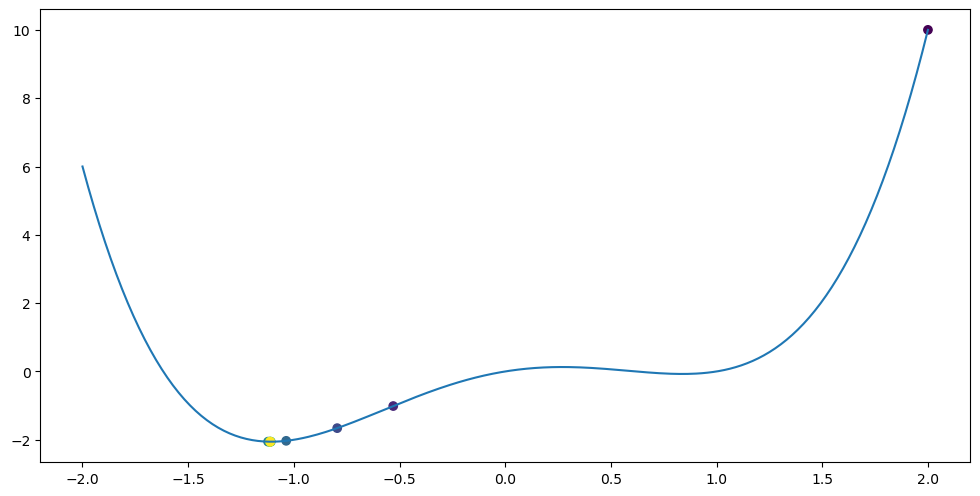

In [118]:

def f(x):
    return x ** 4 - 2 * x ** 2 + x

def f_grad(x):
    return (f(x+0.01) - f(x)) / 0.01

def main():
    optimizer = RMSPropOptimizer(0.8)
    out = optimizer.optimize(f, f_grad, 2.0, iter=10, verbose=True)

    records = optimizer.get_records()

    print(out)

    plt.figure(figsize=(12, 6), dpi=100)

    xs = np.linspace(-2, 2, 300)
    ys = f(xs)
    plt.plot(xs, ys)

    xs = [r[0] for r in records]
    ys = [r[1] for r in records]
    t = np.arange(len(xs))
    plt.scatter(xs, ys, c=t)

    plt.show()



main()